### 1. Model Design

In [1]:
import numpy as np

In [31]:
# activation function and their derivatives
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    s = sigmoid(Z)
    return s * (1 - s)

def softmax(Z):
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return e_Z / e_Z.sum(axis=0, keepdims=True)

activation_functions = {
    "relu": {"function": relu, "derivative": relu_derivative},
    "sigmoid": {"function": sigmoid, "derivative": sigmoid_derivative},
    "softmax": {"function": softmax, "derivative": None}  # Derivative not directly used
}

In [3]:
def initialize_parameters(layer_sizes):
    np.random.seed(1)
    parameters = {}
    L = len(layer_sizes)
    
    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layer_sizes[l], layer_sizes[l-1]) * 0.01
        parameters[f'b{l}'] = np.zeros((layer_sizes[l], 1))
    
    return parameters

In [45]:
def forward_propagation(X, parameters, activations):
    caches = []
    A = X
    
    L = len(parameters) // 2  
    for l in range(1, L + 1):
        W = parameters[f'W{l}']
        b = parameters[f'b{l}']
        A_prev = A
        Z = np.dot(W, A_prev) + b
        A = activation_functions[activations[l-1]]['function'](Z)
        caches.append((A_prev, W, b, Z)) 
    
    return A, caches  

In [5]:
def compute_cost(A, Y, parameters, lambd):
    m = Y.shape[1]
    # Calculate the log probabilities
    log_probs = -np.log(A + 1e-8) * Y  # Element-wise multiplication
    cross_entropy_cost = np.sum(log_probs) / m

    # Add L2 regularization cost
    L2_cost = 0
    L = len(parameters) // 3
    for l in range(1, L + 1):
        W = parameters[f'W{l}']
        L2_cost += (lambd / (2 * m)) * np.sum(np.square(W))

    total_cost = cross_entropy_cost + L2_cost
    return total_cost

In [50]:
def backward_propagation(Y, A_final, caches, parameters, activations, lambd):
    gradients = {}
    L = len(caches)  # The number of layers (except the output layer)
    m = A_final.shape[1]

    # Initialize backpropagation
    # For the last layer, the derivative of the cost with respect to A_final is simply (A_final - Y)
    dZ = A_final - Y

    # Calculate the gradient of the output layer
    A_prev, W, b, Z = caches[1]
    dW = np.dot(dZ, A_prev.T) / m + (lambd * W) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    gradients[f'dW{2}'] = dW
    gradients[f'db{2}'] = db
    dA_prev = np.dot(W.T, dZ)  # Prepare for calculating the gradient of the hidden layer

    # Calculate the gradient of the hidden layer
    A_prev, W, b, Z = caches[0]
    activation = activations[0]
    derivative_function = activation_functions[activation]['derivative']
    dZ = dA_prev * derivative_function(Z)  # Element-wise multiplication of dA and the derivative of Z
    dW = np.dot(dZ, A_prev.T) / m + (lambd * W) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    gradients[f'dW{1}'] = dW
    gradients[f'db{1}'] = db

    return gradients

In [7]:
def update_parameters(parameters, gradients, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        parameters[f'W{l}'] -= learning_rate * gradients[f'dW{l}']
        parameters[f'b{l}'] -= learning_rate * gradients[f'db{l}']
    return parameters

### 2. Model Training

In [8]:
import numpy as np
import gzip

def load_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)
        if data.size == 0:
            raise ValueError("No data loaded; check file path and file integrity.")
        return data / 255.0  # Normalize the data

def load_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        f.read(8)  # Read and skip the header bytes
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        if labels.size == 0:
            raise ValueError("No label data loaded; check file path and file integrity.")
        return labels

# Paths to data files
train_images_path = 'train-images-idx3-ubyte.gz'
train_labels_path = 'train-labels-idx1-ubyte.gz'
test_images_path = 't10k-images-idx3-ubyte.gz'
test_labels_path = 't10k-labels-idx1-ubyte.gz'

In [9]:
X_train = load_images(train_images_path)
X_test = load_images(test_images_path)
print("Initial X_train shape:", X_train.shape)
print("Initial X_test shape:", X_test.shape)

Initial X_train shape: (60000, 784)
Initial X_test shape: (10000, 784)


In [10]:
def one_hot_encode(labels, num_classes=10):
    # Create an array of zeros with length num_classes for each label
    return np.eye(num_classes)[labels]

In [11]:
y_train = load_labels(train_labels_path)
y_test = load_labels(test_labels_path)

print("y_train raw shape:", y_train.shape)
print("y_test raw shape:", y_test.shape)

y_train raw shape: (60000,)
y_test raw shape: (10000,)


In [12]:
# Ensure proper dimensions
X_train = X_train.T
X_test = X_test.T
y_train_encoded = one_hot_encode(y_train).T
y_test_encoded = one_hot_encode(y_test).T

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_encoded.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test_encoded.shape)

X_train shape: (784, 60000)
y_train shape: (10, 60000)
X_test shape: (784, 10000)
y_test shape: (10, 10000)


In [13]:
def compute_accuracy(output, labels):
    predictions = np.argmax(output, axis=0)
    labels = np.argmax(labels, axis=0)
    return np.mean(predictions == labels)

In [33]:
def train_and_evaluate_model(X_train, y_train, X_val, y_val, layer_sizes, activations, learning_rate, num_iterations, lambd):
    parameters = initialize_parameters(layer_sizes)
    train_costs = []
    val_costs = []
    val_accuracies = []
    best_accuracy = 0
    best_params = None
    
    for i in range(num_iterations):
        # Train on training data
        A_train, caches_train = forward_propagation(X_train, parameters, activations)
        train_cost = compute_cost(A_train, y_train, parameters, lambd)
        train_costs.append(train_cost)
        gradients = backward_propagation(y_train, A_train, caches_train, parameters, activations, lambd)
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        # Evaluate on validation data
        if i % 10 == 0 or i == num_iterations - 1:  # Optionally check more frequently
            A_val, caches_val = forward_propagation(X_val, parameters, activations)
            val_cost = compute_cost(A_val, y_val, parameters, lambd)
            val_costs.append(val_cost)
            accuracy = compute_accuracy(A_val, y_val)
            val_accuracies.append(accuracy)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = parameters.copy()
                
            print(f"Iteration {i}: Train Cost = {train_cost:.4f}, Val Cost = {val_cost:.4f}, Val Accuracy = {accuracy:.4f}")
    
    return best_params, train_costs, val_costs, val_accuracies

In [15]:
import matplotlib.pyplot as plt

def plot_metrics(train_costs, val_costs, val_accuracies):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_costs, label='Training Loss')
    plt.plot(np.arange(len(val_costs)) * 10, val_costs, label='Validation Loss')  # Assuming validation every 10 iterations
    plt.title('Training and Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(val_accuracies)) * 10, val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Iteration 0: Train Cost = 2.3005, Val Cost = 2.3002, Val Accuracy = 0.1088
Iteration 10: Train Cost = 2.2969, Val Cost = 2.2966, Val Accuracy = 0.1438
Iteration 20: Train Cost = 2.2931, Val Cost = 2.2927, Val Accuracy = 0.1729
Iteration 30: Train Cost = 2.2889, Val Cost = 2.2885, Val Accuracy = 0.2272
Iteration 40: Train Cost = 2.2843, Val Cost = 2.2839, Val Accuracy = 0.2583
Iteration 50: Train Cost = 2.2792, Val Cost = 2.2787, Val Accuracy = 0.2617
Iteration 60: Train Cost = 2.2734, Val Cost = 2.2729, Val Accuracy = 0.2524
Iteration 70: Train Cost = 2.2668, Val Cost = 2.2662, Val Accuracy = 0.2405
Iteration 80: Train Cost = 2.2594, Val Cost = 2.2587, Val Accuracy = 0.2282
Iteration 90: Train Cost = 2.2510, Val Cost = 2.2502, Val Accuracy = 0.2173
Iteration 100: Train Cost = 2.2415, Val Cost = 2.2406, Val Accuracy = 0.2089
Iteration 110: Train Cost = 2.2309, Val Cost = 2.2299, Val Accuracy = 0.2037
Iteration 120: Train Cost = 2.2190, Val Cost = 2.2179, Val Accuracy = 0.2021
Iteration 

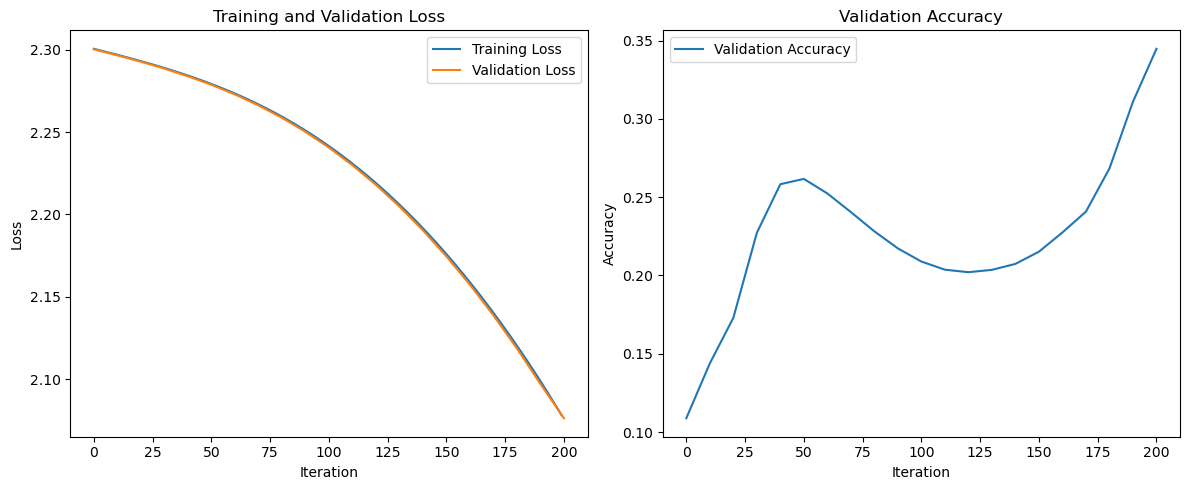

In [51]:
# Test training
layer_sizes = [784, 128, 10]  # For an input layer of 28*28 pixels, one hidden layer, and 10 output classes
activations = ['relu', 'softmax']
best_params, train_costs, val_costs, val_accuracies = train_and_evaluate_model(
    X_train, y_train_encoded, X_test, y_test_encoded, layer_sizes, activations,
    learning_rate=0.01, num_iterations=200, lambd=0.1
)
plot_metrics(train_costs, val_costs, val_accuracies)

### 3. Parameter Tuning

In [54]:
learning_rates = [0.001, 0.01, 0.1]
hidden_layer_sizes = [50, 100, 150]
regularization_strengths = [0.001, 0.01, 0.1]

In [55]:
import numpy as np

def grid_search(X_train, y_train, X_test, y_test):
    results = []
    best_accuracy = 0
    best_params = None
    
    for lr in learning_rates:
        for size in hidden_layer_sizes:
            for lambd in regularization_strengths:
                print(f"Testing with learning rate: {lr}, hidden layer size: {size}, lambda: {lambd}")
                
                layer_sizes = [784, size, 10]  # Adjust the hidden layer size
                activations = ['relu', 'softmax']
                
                params, costs, _, _ = train_and_evaluate_model(
                    X_train, y_train, X_test, y_test, layer_sizes, activations,
                    learning_rate=lr, num_iterations=500, lambd=lambd
                )
                
                final_accuracy = compute_accuracy(forward_propagation(X_test, params, activations)[0], y_test)
                results.append((lr, size, lambd, final_accuracy))
                
                if final_accuracy > best_accuracy:
                    best_accuracy = final_accuracy
                    best_params = {'lr': lr, 'size': size, 'lambda': lambd, 'accuracy': final_accuracy}

                print(f"Accuracy: {final_accuracy}")
    
    return best_params, results

In [56]:
best_params, tuning_results = grid_search(X_train, y_train_encoded, X_test, y_test_encoded)
print("Best Parameters:", best_params)

Testing with learning rate: 0.001, hidden layer size: 50, lambda: 0.001
Iteration 0: Train Cost = 2.3027, Val Cost = 2.3026, Val Accuracy = 0.1432
Iteration 10: Train Cost = 2.3025, Val Cost = 2.3025, Val Accuracy = 0.1451
Iteration 20: Train Cost = 2.3024, Val Cost = 2.3023, Val Accuracy = 0.1478
Iteration 30: Train Cost = 2.3022, Val Cost = 2.3022, Val Accuracy = 0.1504
Iteration 40: Train Cost = 2.3021, Val Cost = 2.3020, Val Accuracy = 0.1521
Iteration 50: Train Cost = 2.3019, Val Cost = 2.3018, Val Accuracy = 0.1541
Iteration 60: Train Cost = 2.3018, Val Cost = 2.3017, Val Accuracy = 0.1565
Iteration 70: Train Cost = 2.3016, Val Cost = 2.3015, Val Accuracy = 0.1593
Iteration 80: Train Cost = 2.3014, Val Cost = 2.3014, Val Accuracy = 0.1607
Iteration 90: Train Cost = 2.3013, Val Cost = 2.3012, Val Accuracy = 0.1628
Iteration 100: Train Cost = 2.3011, Val Cost = 2.3011, Val Accuracy = 0.1647
Iteration 110: Train Cost = 2.3010, Val Cost = 2.3009, Val Accuracy = 0.1665
Iteration 120: 

In [57]:
import pandas as pd

results_df = pd.DataFrame(tuning_results, columns=['Learning Rate', 'Hidden Layer Size', 'Lambda', 'Accuracy'])
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4628\117591612.py:5: FutureWarning: The provided callable <function mean at 0x000001790B5E2200> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = results_df.pivot_table(


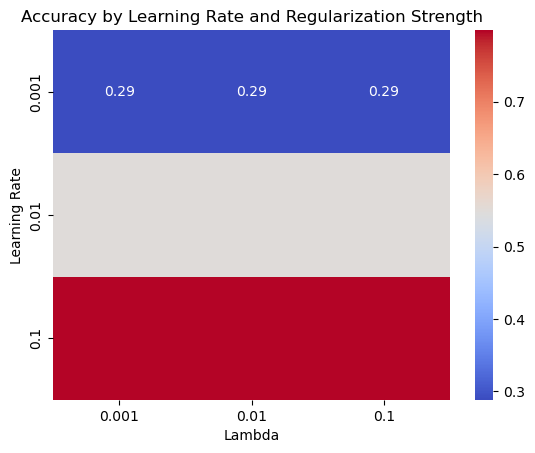

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of accuracy as a function of learning rate and regularization strength for a fixed hidden layer size
pivot_table = results_df.pivot_table(
    index="Learning Rate", 
    columns="Lambda", 
    values="Accuracy", 
    aggfunc=np.mean  
)

sns.heatmap(pivot_table, annot=True, cmap="coolwarm")
plt.title("Accuracy by Learning Rate and Regularization Strength")
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4628\2392557522.py:5: FutureWarning: The provided callable <function mean at 0x000001790B5E2200> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = results_df.pivot_table(


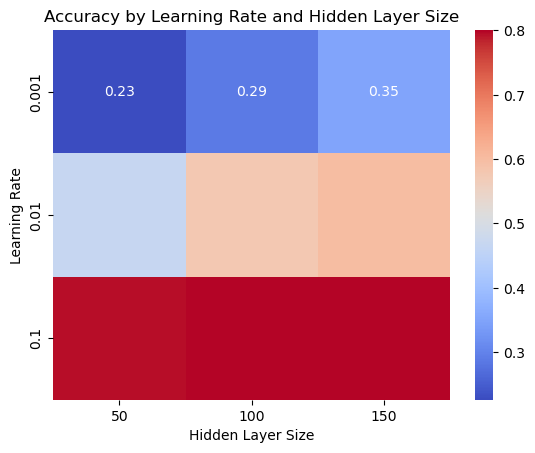

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of accuracy as a function of learning rate and hidden layer size
pivot_table = results_df.pivot_table(
    index="Learning Rate", 
    columns="Hidden Layer Size", 
    values="Accuracy", 
    aggfunc=np.mean  
)

sns.heatmap(pivot_table, annot=True, cmap="coolwarm")
plt.title("Accuracy by Learning Rate and Hidden Layer Size")
plt.xlabel("Hidden Layer Size")
plt.ylabel("Learning Rate")
plt.show()

In [65]:
# Display the top 5 parameter combinations
print(results_df.sort_values(by='Accuracy', ascending=False).head())

    Learning Rate  Hidden Layer Size  Lambda  Accuracy
26            0.1                150   0.100    0.8005
25            0.1                150   0.010    0.8005
24            0.1                150   0.001    0.8005
23            0.1                100   0.100    0.8004
22            0.1                100   0.010    0.8004


### 4. Test and Evaluation

Iteration 0: Train Cost = 2.3014, Val Cost = 2.2975, Val Accuracy = 0.2480
Iteration 10: Train Cost = 2.2451, Val Cost = 2.2353, Val Accuracy = 0.3193
Iteration 20: Train Cost = 2.0738, Val Cost = 2.0481, Val Accuracy = 0.4090
Iteration 30: Train Cost = 1.7629, Val Cost = 1.7337, Val Accuracy = 0.4881
Iteration 40: Train Cost = 1.4867, Val Cost = 1.4680, Val Accuracy = 0.5682
Iteration 50: Train Cost = 1.2921, Val Cost = 1.2819, Val Accuracy = 0.6007
Iteration 60: Train Cost = 1.1539, Val Cost = 1.1500, Val Accuracy = 0.6215
Iteration 70: Train Cost = 1.0540, Val Cost = 1.0547, Val Accuracy = 0.6360
Iteration 80: Train Cost = 0.9802, Val Cost = 0.9844, Val Accuracy = 0.6480
Iteration 90: Train Cost = 0.9244, Val Cost = 0.9314, Val Accuracy = 0.6570
Iteration 100: Train Cost = 0.8811, Val Cost = 0.8903, Val Accuracy = 0.6656
Iteration 110: Train Cost = 0.8468, Val Cost = 0.8576, Val Accuracy = 0.6723
Iteration 120: Train Cost = 0.8188, Val Cost = 0.8310, Val Accuracy = 0.6828
Iteration 

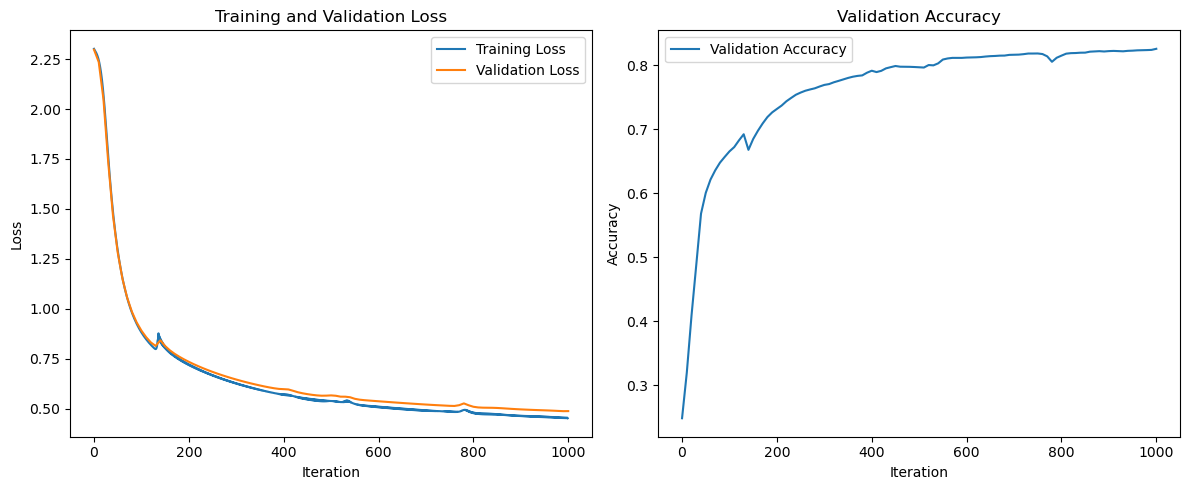

In [59]:
layer_sizes = [784, 150, 10]  # Use the result from grid research
activations = ['relu', 'softmax']
best_params, train_costs, val_costs, val_accuracies = train_and_evaluate_model(
    X_train, y_train_encoded, X_test, y_test_encoded, layer_sizes, activations,
    learning_rate=0.1, num_iterations=1000, lambd=0.001
)
plot_metrics(train_costs, val_costs, val_accuracies)

In [60]:
# Test on the data set
A_test, _ = forward_propagation(X_test, best_params, activations)
test_accuracy = compute_accuracy(A_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8261
